Neural Machine translation (NMT) with Transformer

The Transformer model  is used for language understanding

Encoder and decoder

<img src="images/transformer.png">

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.font_manager import FontProperties
import unicodedata
import re
import numpy as np
import os
import time
from pprint import pprint
import logging

logging.basicConfig(level=40)
np.set_printoptions(suppress=True)
print(tf.__version__)

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2.0.0


In [2]:
output_dir = "nmt"
en_vocab_file = os.path.join(output_dir, "en_vocab")
zh_vocab_file = os.path.join(output_dir, "zh_vocab")
checkpoint_path = os.path.join(output_dir, "checkpoints")
log_dir = os.path.join(output_dir, 'logs')

if not os.path.exists(output_dir):
  os.makedirs(output_dir)
if not os.path.exists(checkpoint_path):
  os.makedirs(checkpoint_path)
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

## Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

```
It is impossible to master English in a short time.	不可能短時間內學會英語。
```

There are a variety of languages available, but we'll use the English-Chinese dataset. After downloading the dataset, here are the steps we'll take to prepare the data:

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [3]:
path_to_file = "datasets/cmn-eng/cmn.txt"

In [4]:
def preprocess_sentence(w):

    #w = w.lower().strip()
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    #w = re.sub(r"([?.!,¿])", r" \1 ", w)
    #w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    #w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)  # should be commented for Chinese
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    #w = '<start> ' + w + ' <end>'
    return w

In [5]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, CHINESE]
def create_dataset(path, num_examples):
    
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = []
    
    for l in lines[:num_examples]:
        w1, w2 = l.split('\t')
        #word_pairs.append((preprocess_sentence(w1), preprocess_sentence(' '.join(w2))))
        word_pairs.append((preprocess_sentence(w1), preprocess_sentence(w2)))
    
    return word_pairs

In [6]:
num_examples = 21064
pairs = create_dataset(path_to_file, num_examples)

In [7]:
shuffle = np.random.permutation(num_examples)
len(shuffle)

21064

In [8]:
data_examples = []
for i in range(num_examples):
    data_examples.append('0')
    
for i, example in enumerate(pairs):
    data_examples[int(shuffle[i])] = example

In [9]:
num_train = 19200
num_valid = num_examples - num_train

In [10]:
train_examples = data_examples[:num_train]
valid_examples = data_examples[num_train:]

In [11]:
pprint(train_examples[:10])

[('I wish to visit Egypt someday.', '我希望有一天去埃及。'),
 ('There were two bridges.', '那裡有兩座橋。'),
 ('I will show you some pictures.', '我會給你們看些照片。'),
 ('Are you sure Tom will come back?', '你確定湯姆會回來嗎？'),
 ("I followed the deer's tracks.", '我跟著鹿的蹤跡。'),
 ('My grandfather lived a long life.', '我的祖父很長壽。'),
 ("You didn't need to buy the book.", '你沒有必要買這本書。'),
 ('I want to go abroad next year.', '我明年想去國外。'),
 ("It's a matter of life and death.", '這是一個生和死的問題。'),
 ('Thank you for drawing a bird for me.', '謝謝你為我畫鳥。')]


Dataset for TensorFlow

In [12]:
train_examples = tf.data.Dataset.from_tensor_slices((
    [en for en, _ in train_examples], [zh for _, zh in train_examples]
))
train_examples

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>

In [13]:
valid_examples = tf.data.Dataset.from_tensor_slices((
    [en for en, _ in valid_examples], [zh for _, zh in valid_examples]
))
valid_examples

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>

建立中文與英文字典

英文字典：

In [14]:
%%time
try:
    subword_encoder_en = tfds.features.text.SubwordTextEncoder.load_from_file(en_vocab_file)
    print(f"Load a built dictionary: {en_vocab_file}")
except:
    print("Build a dictionary from scratch.")
    subword_encoder_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
      (en.numpy() for en, _ in train_examples), 
      target_vocab_size=2**14)
  
    subword_encoder_en.save_to_file(en_vocab_file)

print(f"Vocabulary size: {subword_encoder_en.vocab_size}")
print(f"First 10 subwords: {subword_encoder_en.subwords[:10]}")
print()

Load a built dictionary: nmt/en_vocab
Vocabulary size: 9049
First 10 subwords: ['I_', 'to_', 'the_', 'a_', 'you_', 'is_', 't_', 'Tom_', 'He_', 'in_']

CPU times: user 60 ms, sys: 3.96 ms, total: 63.9 ms
Wall time: 62.5 ms


In [15]:
sample_string = 'Speaking English is useful.'
indices = subword_encoder_en.encode(sample_string)
print(indices)

[3454, 166, 6, 2890, 8839]


In [16]:
print("{0:10}{1:6}".format("Index", "Subword"))
print("-" * 15)

for idx in indices:
    subword = subword_encoder_en.decode([idx])
    print('{0:5}{1:6}'.format(idx, ' ' * 5 + subword))

Index     Subword
---------------
 3454     Speaking 
  166     English 
    6     is 
 2890     useful
 8839     .


為中文建立字典：

In [17]:
%%time
try:
    subword_encoder_zh = tfds.features.text.SubwordTextEncoder.load_from_file(zh_vocab_file)
    print(f"Load a built dictionary: {zh_vocab_file}")
except:
    print("Build a dictionary from scratch.")
    subword_encoder_zh = tfds.features.text.SubwordTextEncoder.build_from_corpus(
      (zh.numpy() for _, zh in train_examples), 
      target_vocab_size=2**13,
      max_subword_length=1)
  
    subword_encoder_zh.save_to_file(zh_vocab_file)

print(f"Vocabulary size: {subword_encoder_zh.vocab_size}")
print(f"First 10 subwords: {subword_encoder_zh.subwords[:10]}")
print()

Load a built dictionary: nmt/zh_vocab
Vocabulary size: 2893
First 10 subwords: ['。', '我', '的', '了', '你', '他', '不', '是', '一', '在']

CPU times: user 11.5 ms, sys: 0 ns, total: 11.5 ms
Wall time: 11.4 ms


In [18]:
sample_string = data_examples[0][1]
indices = subword_encoder_zh.encode(sample_string)

print(sample_string)
print(indices)

我希望有一天去埃及。
[2, 239, 181, 14, 9, 28, 29, 1699, 879, 1]


In [19]:
en = "It says in the Bible, 'Man shall not live on bread alone.'"
zh = "聖經裡有一句話，叫做'人不能只靠麵包生活。'"

en_indices = subword_encoder_en.encode(en)
zh_indices = subword_encoder_zh.encode(zh)

print("English-Chinese sentence pair in dataset:")
print(en)
print(zh)
print()
print('-' * 20)
print()
print("English-Chinese index sequence pair:")
print(en_indices)
print(zh_indices)

English-Chinese sentence pair in dataset:
It says in the Bible, 'Man shall not live on bread alone.'
聖經裡有一句話，叫做'人不能只靠麵包生活。'

--------------------

English-Chinese index sequence pair:
[54, 548, 10, 3, 4803, 13, 8832, 2377, 2485, 37, 255, 22, 2049, 409, 8839, 8832]
[814, 95, 32, 14, 9, 587, 79, 23, 328, 43, 2676, 25, 7, 36, 215, 589, 663, 361, 49, 283, 1, 2676]


前處理數據 (Eager excution)

In [20]:
def encode(en_t, zh_t):
    
    en_indices = [subword_encoder_en.vocab_size] + subword_encoder_en.encode(
      en_t.numpy()) + [subword_encoder_en.vocab_size + 1]
    
    zh_indices = [subword_encoder_zh.vocab_size] + subword_encoder_zh.encode(
      zh_t.numpy()) + [subword_encoder_zh.vocab_size + 1]
  
    return en_indices, zh_indices

def tf_encode(en_t, zh_t):

    return tf.py_function(encode, [en_t, zh_t], [tf.int64, tf.int64])

長度超過 60 個 tokens 的序列都去掉

In [21]:
MAX_LENGTH = 60

def filter_max_length(en, zh, max_length=MAX_LENGTH):

  return tf.logical_and(tf.size(en) <= max_length,
                        tf.size(zh) <= max_length)

Build training dataset and validation dataset

In [22]:
MAX_LENGTH = 60
BATCH_SIZE = 64
BUFFER_SIZE = 19200

train_dataset = (train_examples
                 .map(tf_encode)
                 .filter(filter_max_length)
                 .cache()
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE,
                               padded_shapes=([-1], [-1]))
                 .prefetch(tf.data.experimental.AUTOTUNE))
valid_dataset = (valid_examples
               .map(tf_encode)
               .filter(filter_max_length)
               .padded_batch(BATCH_SIZE, 
                             padded_shapes=([-1], [-1])))

In [23]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)  # scale by sqrt(dk)

  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
  
  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [24]:
def create_padding_mask(seq):

  mask = tf.cast(tf.equal(seq, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :] #　broadcasting

In [25]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [26]:
def split_heads(x, d_model, num_heads):
  # x.shape: (batch_size, seq_len, d_model)
  batch_size = tf.shape(x)[0]

  assert d_model % num_heads == 0
  depth = d_model // num_heads

  # (batch_size, seq_len, num_heads, depth)
  reshaped_x = tf.reshape(x, shape=(batch_size, -1, num_heads, depth))

  # (batch_size, num_heads, seq_len, depth)
  output = tf.transpose(reshaped_x, perm=[0, 2, 1, 3])
  
  return output

Multi-Head Attention

In [27]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
 
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    # (batch_size, seq_len_q, num_heads, depth)
    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model)) 
    # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

Position-wise Feed-Forward Networks

In [28]:
def point_wise_feed_forward_network(d_model, dff):

  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

Encoder layer：Encoder

In [29]:
class EncoderLayer(tf.keras.layers.Layer):
  
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):
    # sub-layer 1: MHA
    attn_output, attn = self.mha(x, x, x, mask)  
    attn_output = self.dropout1(attn_output, training=training) 
    out1 = self.layernorm1(x + attn_output)  
    
    # sub-layer 2: FFN
    ffn_output = self.ffn(out1) 
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)
    
    return out2

Decoder layer：Decoder

In [30]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           combined_mask, inp_padding_mask):
    # sub-layer 1: Decoder layer
    attn1, attn_weights_block1 = self.mha1(x, x, x, combined_mask)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    # sub-layer 2: Decoder layer
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, inp_padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    # sub-layer 3: FFN
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

Positional encoding:

In [31]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  sines = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  cosines = np.cos(angle_rads[:, 1::2])
  
  pos_encoding = np.concatenate([sines, cosines], axis=-1)
  
  pos_encoding = pos_encoding[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

Encoder：

Embedding layer、Position encoding、N Encoder layers

In [32]:
class Encoder(tf.keras.layers.Layer):
  
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):
    
    input_seq_len = tf.shape(x)[1]

    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :input_seq_len, :]

    x = self.dropout(x, training=training)
    
    for i, enc_layer in enumerate(self.enc_layers):
      x = enc_layer(x, training, mask)

    return x

Decoder

In [33]:
class Decoder(tf.keras.layers.Layer):

  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, 
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(target_vocab_size, self.d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
  
  def call(self, x, enc_output, training, 
           combined_mask, inp_padding_mask):
    
    tar_seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, tar_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :tar_seq_len, :]
    x = self.dropout(x, training=training)

    
    for i, dec_layer in enumerate(self.dec_layers):
      x, block1, block2 = dec_layer(x, enc_output, training,
                                    combined_mask, inp_padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2
    
    # x.shape == (batch_size, tar_seq_len, d_model)
    return x, attention_weights

 Transformer：

Encoder、Decoder、Final linear layer

In [34]:
class Transformer(tf.keras.Model):

  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, enc_padding_mask, 
           combined_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, combined_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

Loss function and performance metric

In [35]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

Hyper Parameters

In [36]:
batch_size = 64
num_layers = 6 #4 
d_model = 512 #128
dff = 2048 #512
num_heads = 8

input_vocab_size = subword_encoder_zh.vocab_size + 2
target_vocab_size = subword_encoder_en.vocab_size + 2
dropout_rate = 0.1  # default value in paper

print("input_vocab_size:", input_vocab_size)
print("target_vocab_size:", target_vocab_size)

input_vocab_size: 2895
target_vocab_size: 9051


Optimizer

In [37]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [38]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, dropout_rate)

print(f"""This Transformer has {num_layers} - Encoder/Decoder layers
d_model: {d_model}
num_heads: {num_heads}
dff: {dff}
input_vocab_size: {input_vocab_size}
target_vocab_size: {target_vocab_size}
dropout_rate: {dropout_rate}

""")

This Transformer has 6 - Encoder/Decoder layers
d_model: 512
num_heads: 8
dff: 2048
input_vocab_size: 2895
target_vocab_size: 9051
dropout_rate: 0.1




checkpoint

In [39]:
run_id = f"{num_layers}layers_{d_model}d_{num_heads}heads_{dff}dff"
checkpoint_path = os.path.join(checkpoint_path, run_id)
log_dir = os.path.join(log_dir, run_id)

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)

  last_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])
  print(f'Load the latest checkpoint, the model has been trained for {last_epoch} epochs。')
else:
  last_epoch = 0
  print("Train the model from scratch")

Load the latest checkpoint, the model has been trained for 300 epochs。


Create masks

In [40]:
def create_masks(inp, tar):

  enc_padding_mask = create_padding_mask(inp)

  dec_padding_mask = create_padding_mask(inp)

  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

Training per Step

In [41]:
@tf.function
def train_step(inp, tar):

  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  # 3 masks
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  with tf.GradientTape() as tape:

    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)

    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(tar_real, predictions)

Training

In [42]:
EPOCHS = 200
print(f"This Transformer has been trained for {last_epoch} epochs。")
print(f"Remaining epochs：{min(0, last_epoch - EPOCHS)}")


# Record training information to TensorBoard
summary_writer = tf.summary.create_file_writer(log_dir)
%load_ext tensorboard
%tensorboard --logdir {log_dir}

for epoch in range(last_epoch, EPOCHS):
    start = time.time()
  
    # Reset recorded metrics in TensorBoard
    train_loss.reset_states()
    train_accuracy.reset_states()
  
    for (step_idx, (tar, inp)) in enumerate(train_dataset):
        train_step(inp, tar)  

    if (epoch + 1) % 1 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
    # Record loss and accuracy to TensorBoard
    with summary_writer.as_default():
        tf.summary.scalar("train_loss", train_loss.result(), step=epoch + 1)
        tf.summary.scalar("train_acc", train_accuracy.result(), step=epoch + 1)

    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

This Transformer has been trained for 300 epochs。
Remaining epochs：0


evaluation

In [43]:
def translate(inp_sentence):

  start_token = [subword_encoder_zh.vocab_size]
  end_token = [subword_encoder_zh.vocab_size + 1]

  inp_sentence = start_token + subword_encoder_zh.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  decoder_input = [subword_encoder_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
  

  for i in range(MAX_LENGTH):

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    predictions = predictions[: , -1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    if tf.equal(predicted_id, subword_encoder_en.vocab_size + 1):
      return tf.squeeze(output, axis=0), attention_weights

    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

Chinese sentences

In [44]:
sentence1 = "不可能短時間內學會英語。"
sentence2 = "你可以告訴我要怎麼去火車站嗎?"
sentence3 = "如果明天天氣好，我們就去野餐。"
sentence4 = "真正的友誼比金錢更有價值。"
sentence5 = "聖經裡有一句話，叫做“人不能只靠麵包生活”。"
sentence6 = "每次我讀聖經都會被深深地感動。"

sentences = []

sentences.append(sentence1)
sentences.append(sentence2)
sentences.append(sentence3)
sentences.append(sentence4)
sentences.append(sentence5)
sentences.append(sentence6)

Translate Chinese to English

In [45]:
for sentence in sentences:
    predicted_seq, _ = translate(sentence)

    target_vocab_size = subword_encoder_en.vocab_size
    predicted_seq_without_bos_eos = [idx for idx in predicted_seq if idx < target_vocab_size]
    predicted_sentence = subword_encoder_en.decode(predicted_seq_without_bos_eos)

    print("Chinese sentence:", sentence)
    print("English sentence:", predicted_sentence)
    print("-" * 20)

Chinese sentence: 不可能短時間內學會英語。
English sentence: It is impossible to master English in a short time.
--------------------
Chinese sentence: 你可以告訴我要怎麼去火車站嗎?
English sentence: Can you tell me how to go to the station?
--------------------
Chinese sentence: 如果明天天氣好，我們就去野餐。
English sentence: If it is fine tomorrow, we'll go on a picnic.
--------------------
Chinese sentence: 真正的友誼比金錢更有價值。
English sentence: Real friendship is more valuable than money.
--------------------
Chinese sentence: 聖經裡有一句話，叫做“人不能只靠麵包生活”。
English sentence: It says in the Bible, "Man shall not live on bread alone."
--------------------
Chinese sentence: 每次我讀聖經都會被深深地感動。
English sentence: Every time I read the Bible, I am deeply moved.
--------------------


In [46]:
sentence = "當你說英語的時候不要怕犯錯。"
predicted_seq, _ = translate(sentence)

target_vocab_size = subword_encoder_en.vocab_size
predicted_seq_without_bos_eos = [idx for idx in predicted_seq if idx < target_vocab_size]
predicted_sentence = subword_encoder_en.decode(predicted_seq_without_bos_eos)

print("Chinese sentence:", sentence)
print("English sentence:", predicted_sentence)
print("-" * 20)

Chinese sentence: 當你說英語的時候不要怕犯錯。
English sentence: Don't be afraid of making mistakes when you speak English.
--------------------


In [47]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  20396544  
_________________________________________________________________
decoder (Decoder)            multiple                  29858304  
_________________________________________________________________
dense_96 (Dense)             multiple                  4643163   
Total params: 54,898,011
Trainable params: 54,898,011
Non-trainable params: 0
_________________________________________________________________


Visualize attention weights

In [48]:
predicted_seq, attention_weights = translate(sentence)

layer_name = f"decoder_layer{num_layers}_block2"

print("sentence:", sentence)
print("-" * 20)
print("predicted_seq:", predicted_seq)
print("-" * 20)
print("attention_weights.keys():")
for layer_name, attn in attention_weights.items():
  print(f"{layer_name}.shape: {attn.shape}")
print("-" * 20)
print("layer_name:", layer_name)

sentence: 當你說英語的時候不要怕犯錯。
--------------------
predicted_seq: tf.Tensor([9049   93 8832    7   32  244   11  643 1440  127    5  132  168 8839], shape=(14,), dtype=int32)
--------------------
attention_weights.keys():
decoder_layer1_block1.shape: (1, 8, 14, 14)
decoder_layer1_block2.shape: (1, 8, 14, 16)
decoder_layer2_block1.shape: (1, 8, 14, 14)
decoder_layer2_block2.shape: (1, 8, 14, 16)
decoder_layer3_block1.shape: (1, 8, 14, 14)
decoder_layer3_block2.shape: (1, 8, 14, 16)
decoder_layer4_block1.shape: (1, 8, 14, 14)
decoder_layer4_block2.shape: (1, 8, 14, 16)
decoder_layer5_block1.shape: (1, 8, 14, 14)
decoder_layer5_block2.shape: (1, 8, 14, 16)
decoder_layer6_block1.shape: (1, 8, 14, 14)
decoder_layer6_block2.shape: (1, 8, 14, 16)
--------------------
layer_name: decoder_layer6_block2


In [49]:
import matplotlib as mpl

zhfont = mpl.font_manager.FontProperties(fname='/usr/share/fonts/truetype/wqy/wqy-microhei.ttc')
plt.style.use("seaborn-whitegrid")

def plot_attention_weights(attention_weights, sentence, predicted_seq, layer_name, max_len_tar=None):
    
  fig = plt.figure(figsize=(17, 7))
  
  sentence = subword_encoder_zh.encode(sentence)
  
  if max_len_tar:
    predicted_seq = predicted_seq[:max_len_tar]
  else:
    max_len_tar = len(predicted_seq)
  
  attention_weights = tf.squeeze(attention_weights[layer_name], axis=0)  
  # (num_heads, tar_seq_len, inp_seq_len)
  
  for head in range(attention_weights.shape[0]):
    ax = fig.add_subplot(2, 4, head + 1)

    #attn_map = np.transpose(attention_weights[head][:max_len_tar, :])
    attn_map = attention_weights[head][:max_len_tar, :]
    ax.matshow(attn_map, cmap='viridis')  # (inp_seq_len, tar_seq_len)
    
    fontdict = {"fontproperties": zhfont}
    
    ax.set_yticks(range(max(max_len_tar, len(predicted_seq))))
    ax.set_ylim(-0.5, max_len_tar -1.5)
    
    ax.set_xticks(range(len(sentence) + 2))
    ax.set_yticklabels([subword_encoder_en.decode([i]) for i in predicted_seq 
                        if i < subword_encoder_en.vocab_size], 
                       fontdict=fontdict, fontsize=18)    
    
    ax.set_xticklabels(
        ['<start>'] + [subword_encoder_zh.decode([i]) for i in sentence] + ['<end>'], 
        fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head + 1))
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
  
  plt.tight_layout()
  plt.show()
  plt.close(fig)

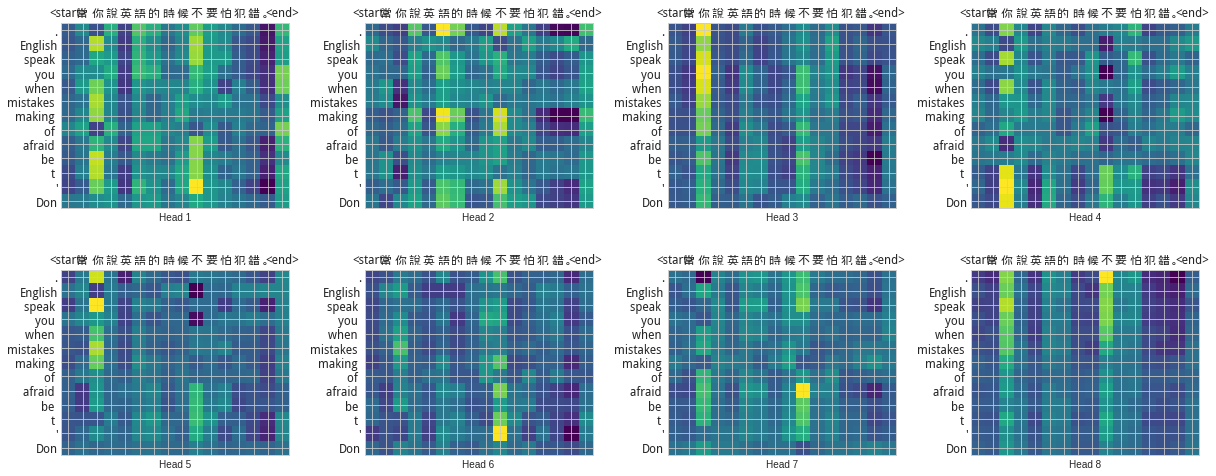

In [50]:
plot_attention_weights(attention_weights, sentence, 
                       predicted_seq, layer_name, max_len_tar=None)